In [1]:
# Required Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import PySpark only if Spark is used
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col
except ImportError:
    SparkSession = None

In [3]:
# Fraud Detection Project Class
class FraudDetectionProject:
    def __init__(self, use_local=False):
        self.dataset_url = 'https://www.kaggle.com/mlg-ulb/creditcardfraud/download'
        self.dataset_path = 'data/creditcard.csv'
        self.model_path = 'models/fraud_detection_model.pkl'
        self.use_local = use_local
        self.spark = None
        self.df_spark = None
        self.df_pandas = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.results = {}

        if not self.use_local and SparkSession is not None:
            self.spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
    
    def load_data(self):
        if not self.use_local and self.spark is not None:
            # Read dataset into a Spark DataFrame
            self.df_spark = self.spark.read.csv(self.dataset_path, header=True, inferSchema=True)
        else:
            # Load the dataset locally with Pandas
            self.df_pandas = pd.read_csv(self.dataset_path)
    
    def preprocess_data(self):
        if not self.use_local and self.spark is not None:
            # Spark Preprocessing
            self.df_spark = self.df_spark.withColumn("Class", col("Class").cast("integer"))
            
            # Balance the dataset
            fraud_cases = self.df_spark.filter(self.df_spark['Class'] == 1)
            non_fraud_cases = self.df_spark.filter(self.df_spark['Class'] == 0).sample(fraction=0.1)
            balanced_data = fraud_cases.union(non_fraud_cases)
            
            # Convert Spark DataFrame to Pandas DataFrame
            self.df_pandas = balanced_data.toPandas()
        else:
            # Local Pandas Preprocessing
            # Balance the dataset locally
            fraud_cases = self.df_pandas[self.df_pandas['Class'] == 1]
            non_fraud_cases = self.df_pandas[self.df_pandas['Class'] == 0].sample(frac=0.1, random_state=42)
            self.df_pandas = pd.concat([fraud_cases, non_fraud_cases])

        # Split data into X (features) and y (target)
        X = self.df_pandas.drop(columns=['Class'])
        y = self.df_pandas['Class']
        
        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    def train_model(self, model_name, model, param_grid=None):
        # Train a model with optional hyper-parameter tuning
        if param_grid:
            grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
            grid_search.fit(self.X_train, self.y_train)
            best_model = grid_search.best_estimator_
            self.models[model_name] = best_model
        else:
            model.fit(self.X_train, self.y_train)
            self.models[model_name] = model
    
    def evaluate_model(self, model_name):
        # Evaluate the trained model and store the results
        model = self.models[model_name]
        y_pred = model.predict(self.X_test)
        
        # Store evaluation metrics
        self.results[model_name] = {
            'confusion_matrix': confusion_matrix(self.y_test, y_pred),
            'classification_report': classification_report(self.y_test, y_pred),
            'accuracy_score': accuracy_score(self.y_test, y_pred),
            'y_pred': y_pred
        }

        try:
            self.results[model_name] = {
                'roc_auc': roc_auc_score(self.y_test, model.predict_proba(self.X_test)[:, 1]),
            }
        except AttributeError:
            pass

    def print_results(self, model_name):
        # Print the evaluation metrics for a specific model
        print(f"Results for {model_name}:\n")
        print(f"Confusion Matrix:\n{self.results[model_name]['confusion_matrix']}\n")
        print(f"Classification Report:\n{self.results[model_name]['classification_report']}\n")
        print(f"Accuracy: {self.results[model_name]['accuracy_score']:.4f}\n")
        if 'roc_auc' in self.results.keys():
            print(f"ROC-AUC: {self.results[model_name]['roc_auc']:.4f}\n")

    def visualize_learning_curves(self, model_name):
        # Visualize learning curves to check for overfitting
        train_sizes, train_scores, test_scores = learning_curve(
            self.models[model_name],
            self.X_train, self.y_train,
            cv=5, scoring='accuracy', n_jobs=-1
        )
        plt.figure(figsize=(25.6, 16))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
        plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Validation score')
        plt.xlabel('Training examples')
        plt.ylabel('Score')
        plt.title(f'Learning Curves for {model_name}')
        plt.legend(loc='best')
        plt.show()
    
    def visualize_confusion_matrix(self, model_name):
        # Visualize the confusion matrix for the specified model
        matrix = self.results[model_name]['confusion_matrix']
        # plt.figure(figsize=(25.6, 16))
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    def visualize_correlation_heatmap(self):
        # Visualize a heatmap of correlations between features
        correlation_matrix = self.df_pandas.corr()
        plt.figure(figsize=(25.6, 16))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title("Correlation Heatmap")
        plt.show()
    
    def run_experiments(self):
        # Random Forest with Hyper-Parameter Tuning
        param_grid_rf = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        }
        self.train_model("RandomForest", RandomForestClassifier(), param_grid_rf)
        self.evaluate_model("RandomForest")
        
        # Gradient Boosting (XGBoost) with Hyper-Parameter Tuning
        param_grid_gb = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
        self.train_model("GradientBoosting", GradientBoostingClassifier(), param_grid_gb)
        self.evaluate_model("GradientBoosting")
        
        # Logistic Regression (Standard)
        self.train_model("LogisticRegression", LogisticRegression(max_iter=1000))
        self.evaluate_model("LogisticRegression")
        
        # Support Vector Machine with Hyper-Parameter Tuning
        param_grid_svm = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
        self.train_model("SVM", SVC(), param_grid_svm)
        self.evaluate_model("SVM")
        
        # K-Nearest Neighbors with Hyper-Parameter Tuning
        param_grid_knn = {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
        self.train_model("KNN", KNeighborsClassifier(), param_grid_knn)
        self.evaluate_model("KNN")
    
    def visualize_all_results(self):
        for model_name in self.models.keys():
            self.print_results(model_name)
            self.visualize_confusion_matrix(model_name)
    
    def compare_accuracies(self):
        # Create an interactive bar chart comparing accuracies of different models
        model_names = list(self.results.keys())
        accuracies = [self.results[model]['accuracy_score'] for model in model_names]
        
        # Define min and max range for accuracy based on the data
        min_accuracy = min(accuracies) - 0.01
        max_accuracy = max(accuracies) + 0.01
        
        fig = go.Figure(data=[
            go.Bar(name='Accuracy', x=model_names, y=accuracies, marker_color='blue')
        ])
        
        fig.update_layout(
            title='Model Comparison - Accuracy Scores',
            xaxis_title='Model',
            yaxis_title='Accuracy',
            yaxis=dict(range=[max(0, min_accuracy), min(1, max_accuracy)]),
            template='plotly_white'
        )
        
        fig.show()

## Local Execution

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


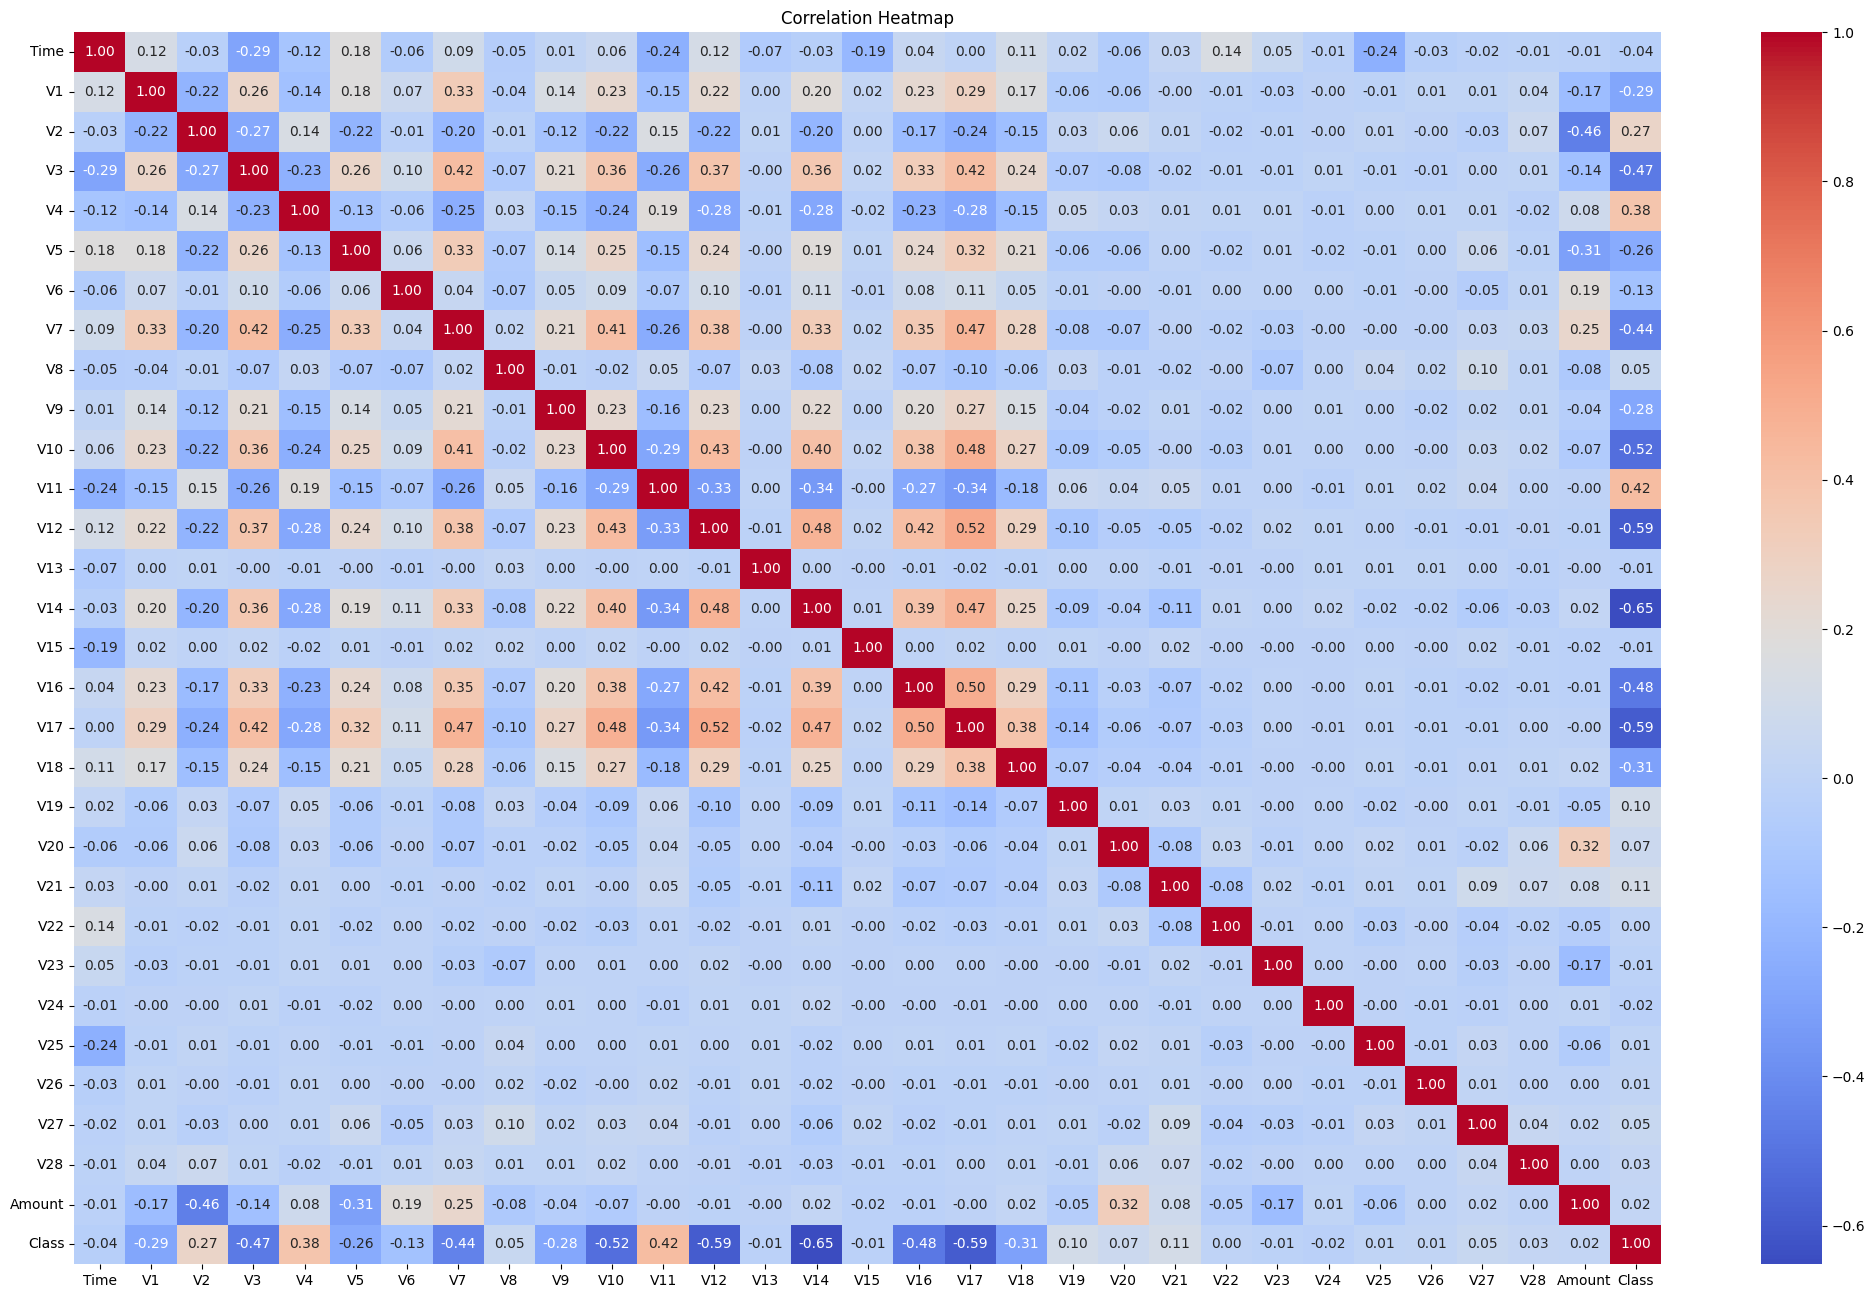

Results for RandomForest:



KeyError: 'confusion_matrix'

In [4]:
# Create an instance of the project with the `use_local` flag
# Set use_local=True to run locally, use_local=False to run with Spark
fraud_project = FraudDetectionProject(use_local = True)

# Load data and initialize
fraud_project.load_data()

# Preprocess the data and split into training and testing sets
fraud_project.preprocess_data()

# Run experiments with various algorithms
fraud_project.run_experiments()

# Visualize correlation heatmap and confusion matrices for all models
fraud_project.visualize_correlation_heatmap()
fraud_project.visualize_all_results()

# Compare accuracies of different models
fraud_project.compare_accuracies()

In [ ]:
# Print detailed results and learning curves for RandomForest
fraud_project.print_results("RandomForest")
fraud_project.visualize_learning_curves("RandomForest")

## Using PySpark

In [ ]:
fraud_project = FraudDetectionProject()

# Load data and initialize
fraud_project.load_data()

# Preprocess the data and split into training and testing sets
fraud_project.preprocess_data()

# Run experiments with various algorithms
fraud_project.run_experiments()

# Visualize correlation heatmap and confusion matrices for all models
fraud_project.visualize_correlation_heatmap()
fraud_project.visualize_all_results()

# Compare accuracies of different models
fraud_project.compare_accuracies()

PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.